### Setup

In [1]:
import collections
import random
from random import  uniform as ru
from math import *
import scipy.optimize as opt
import math 
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.special import binom
from copy import copy
import numpy as np
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

def log2(x):
    return log(x,2)

def Hi(v):
    if v==1:
        return 0.5
    return fsolve(lambda x:v -(-x*log2(x)-(1-x)*log2(1-x)),0.0000001)[0]

def Hqi(v,q):
    if v==1:
        return 1-1/q
    return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]

def H(c):
    """
    Entropy function
    """
    if c == 0. or c == 1.:
        return 0.
    
    if c < 0. or c > 1.:
        return -1000
    
    return -(c * log2(c) + (1 - c) * log2(1 - c))

def binomH(n,k):
    """
    binomial coefficient
    """
    # if k/n not in ZZ:
    #     return -100
    if(n<=0):
        return 0.
    return n * H(k/n)

def multiH(n,c):
    """
    multinomial coefficient
    """
    if sum(c)>n:
        return 0
    tot=0
    val=n
    for i in c:
        tot+=binomH(n,i)
        n-=i
    return tot

def wrap(f,g) :
    def inner(x):
        return f(g(*x))
    return inner

def r(x,y,z):
    return [(ru(x,y)) for i in range(z)]

def check_constraints(constraints, solution) : 
    return [ (constraint['type'], constraint['fun'](solution)) for constraint in constraints ]

def validity(mycons, result):
    const= check_constraints(mycons, result)
    for i in const:
        if i[0]=="eq":
            if abs(i[1])>1e-7:
                return False
        elif i[1]<-1e-7:
            return False
    return True

def reps(ell,p_target,p_addends):
    return binomH(p_target, p_target/2)+binomH(ell-p_target,p_addends-p_target/2)

# those are set in the loop later, definition here just took make them available
k = lambda x : 0
w = lambda x : 0

### q = 3, MMT two levels, variable number of 1's and 2's in base list

In [17]:
set_vars = collections.namedtuple('Our', 'p p2 ell')
def our(f) : return wrap(f, set_vars)
k=0.5
w=0.1

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)

p1 = lambda x: x.p/4+x.p/2-2*x.p2
r1 = lambda x: binomH(x.p/2,x.p/4) + binomH(x.p/2,x.p2) + binomH(x.p/2-x.p2,x.p2)
L0 = lambda x: binomH((k+x.ell)/2,p1(x)/2)+ binomH((k+x.ell-p1(x))/2,x.p2/2)
L1 = lambda x: 2*L0(x)-r1(x)

T2 = lambda x: 2*L1(x) - (log2(3)*x.ell-r1(x))

constraints = [
    #{ 'type' : 'eq',   'fun' : our(lambda x : x.p2 - x.p/4)},    
    { 'type' : 'ineq',   'fun' : our(lambda x : k+ x.ell - x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-2*x.p2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : k+ x.ell - x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell- (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)}
]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    if x.p/2-2*x.p2<0:
        return 100
    return perms(x) + max(L0(x),L1(x),T2(x))

def optimize(verb=False):
    
    start = r(0,0.008,3)
    bounds = [(0, 1)]*3
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

In [18]:
x=set_vars( 1.141e-02,  2.774e-03,  3.269e-02)

In [19]:
r1(x),x.p

(0.012290149776731998, 0.01141)

In [20]:
x.p/4,x.p2

(0.0028525, 0.002774)

In [21]:
time(x)

0.10158068384848343

In [22]:
iterate_optimizer(100)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.10157673650398087
       x: [ 1.121e-02  2.738e-03  3.216e-02]
     nit: 32
     jac: [ 4.578e+00 -8.619e-02 -1.177e+00]
    nfev: 195
    njev: 32

In [23]:
k=0.5
w=0.1

### MMT

In [24]:
set_vars = collections.namedtuple('Our', 'p ell')
def our(f) : return wrap(f, set_vars)
k=0.5
w=0.1

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)

p1 = lambda x: x.p/2
r1 = lambda x: x.p
L0 = lambda x: binomH((k+x.ell)/2,p1(x)/2)+p1(x)/2
L1 = lambda x: 2*L0(x)-r1(x)

T2 = lambda x: 2*L1(x) - (log2(3)*x.ell-r1(x))

constraints = [
    
    { 'type' : 'ineq',   'fun' : our(lambda x : k+ x.ell - x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1- k- x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell- (w-x.p))}
]

def memory(x):
    x = set_vars(*x)    
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)    

    return perms(x) + max(L0(x),L1(x),T2(x))

def optimize(verb=False):
    
    start = r(0,0.008,2)
    bounds = [(0, 1)]*2
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result
    
def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

In [25]:
iterate_optimizer(100)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.1017567899164444
       x: [ 1.073e-02  3.068e-02]
     nit: 43
     jac: [ 3.075e+00  2.896e-01]
    nfev: 233
    njev: 43

### Stern/Dumer

In [26]:
set_vars = collections.namedtuple('Our', 'p ell')
def our(f) : return wrap(f, set_vars)

k = 0.5
q = 2
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)

L0 = lambda x: binomH((k+x.ell)/2,x.p/2)+ (x.p/2)*log2(q-1)
L1 = lambda x: 2*L0(x) - x.ell*log2(q)

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell- (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    return perms(x) + max(L0(x),L1(x))

def optimize(verb=False):
    variables=2
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*variables
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100000
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_2832\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [27]:
res=iterate_optimizer(100)
x=set_vars( *res.x)
res.fun

0.1151516650648495

In [28]:
t = 3

def addt(x):
    return x+t
    
def hej(x):
    global t
    t = x
    print(addt(0))

hej(2)
print(t)


2
2


In [29]:
print(x.p,"p")
print(x.ell,"ell")

0.010418527502531597 p
0.037071735295719124 ell


In [30]:
for q in [2,3,4,5,7,9,11,13,17,19]:
    ks = [0.1,0.5,0.9]
    times = []
    for k in ks:
        w = Hqi(1-k,q)
        res=iterate_optimizer(100)
        times.append(res.fun)
    print(ks,times)
    while max(times)-min(times) > 0.0004:
        if times[0] > times [2]:
            k  = ks[0] + 2/3*(ks[1]-ks[0])
            ks = [ ks[0] , k]
            w  = Hqi(1-k,q)
            res=iterate_optimizer(100)
            times = [times[0], res.fun]
        else:
            k  = ks[1] - 2/3*(ks[1]-ks[0])
            ks = [ k , ks[1]]
            w  = Hqi(1-k,q)
            res=iterate_optimizer(100)
            times = [res.fun, times[1]]

        print(ks,times)
    print(q, (ks[1]+ks[0])/2)
            

C:\Users\freja\AppData\Local\Temp\ipykernel_2832\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


[0.1, 0.5, 0.9] [0.057281455298317796, 0.11515166505467905, 0.040469956242720706]
[0.1, 0.3666666666666667] [0.057281455298317796, 0.11364069149659542]


IndexError: list index out of range

In [ ]:
Sterns = []
ks = np.arange(0.05,1,0.05)
for k in ks:
    w = Hqi(1-k,q)
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    Sterns.append(res.fun)

In [ ]:
k = 0.5
Sterns_w = []
wmax = 2 * Hqi(1-k,q)
ws = [wmax/20*i for i in range(1,20)]
for w in ws:
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    Sterns_w.append(res.fun)

In [ ]:
k = 0.5
qs = range(50,1000,50)
Sterns_q = []
for q in qs:
    w = Hqi(1-k,q)
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    Sterns_q.append(res.fun)

### Paolos meet in the middle

In [ ]:
set_vars = collections.namedtuple('Our', 'p d ell i')
def our(f) : return wrap(f, set_vars)
    
k = 0.5
q = 50
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)

p1 = lambda x: x.p/2+x.d
r1 = lambda x: binomH(x.p-2*x.i,x.p/2 - x.i) + binomH(x.p,2*x.i) + 2*x.i*log2(q-2) + binomH(k+x.ell-x.p,x.d-x.i) + (x.d-x.i)*log2(q-1)
L0 = lambda x: binomH(k+x.ell,p1(x))
T1 = lambda x: 2*L0(x) - (x.ell-p1(x))*log2(q)
L1 = lambda x: binomH(k+x.ell,x.p)+x.p*log2(q-1)-x.ell*log2(q)
P  = lambda x: min(0,r1(x)-p1(x)*log2(q))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p - x.d)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell- (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-x.i)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d-x.i)},
    { 'type' : 'ineq',   'fun' : our(lambda x : r1(x)-p1(x)*log2(q))}
]

def memory(x):
    return max(L0(x),P(x)+L1(x))

def time(x):
    x = set_vars(*x)  
    return -P(x) + perms(x) + max(L0(x),T1(x))

def optimize(verb=False):
    variables=4
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*variables
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=10000
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_8076\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [ ]:
res=iterate_optimizer(100)
x=set_vars( *res.x)
res.fun

0.463613175640554

In [ ]:
# Pranges
print(binomH(1., w) - binomH(1-k, w))

0.46894285119697365


In [ ]:
#Compare representations to number of fixed variables on first level
print(r1(x),"representations")
print(p1(x)*log2(q),"q^p1")
print(max(0,p1(x)*log2(q)-r1(x)))

0.006584261406304399 representations
0.0065841822568182655 q^p1
0


In [ ]:
print(x.p,"p")
print(x.d,"d")
print(x.i,"i")
print(x.ell,"ell")

0.008167897527788261 p
0.00169438723614302 d
0.0007262311302872216 i
0.012654275222554572 ell


In [ ]:
Pranges = []
Paolos = []
for k in ks:
    w = Hqi(1-k,q)
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    Paolos.append(res.fun)
    Pranges.append(binomH(1., w) - binomH(1-k, w))


C:\Users\freja\AppData\Local\Temp\ipykernel_8076\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [ ]:
k = 0.5
Paolos_w = []
for w in ws:
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    Paolos_w.append(res.fun)

In [ ]:
k = 0.5
qs = range(50,1000,50)
Paolos_q = []
for q in qs:
    w = Hqi(1-k,q)
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    Paolos_q.append(res.fun)

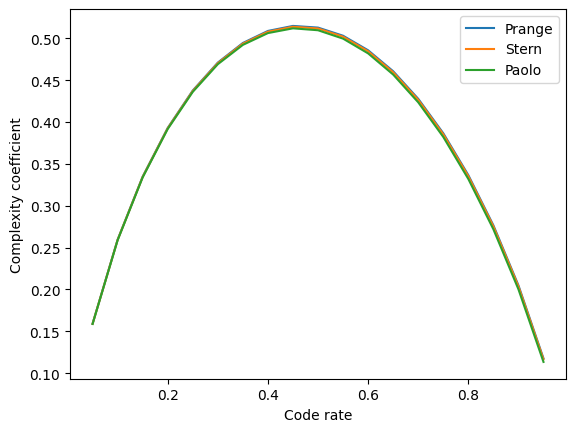

In [ ]:
plt.plot(ks, Pranges, label = "Prange")
plt.plot(ks, Sterns, label = "Stern")
plt.plot(ks, Paolos, label = "Paolo")
plt.legend()
plt.xlabel("Code rate")
plt.ylabel("Complexity coefficient")

plt.savefig("paolos_MitM.png")

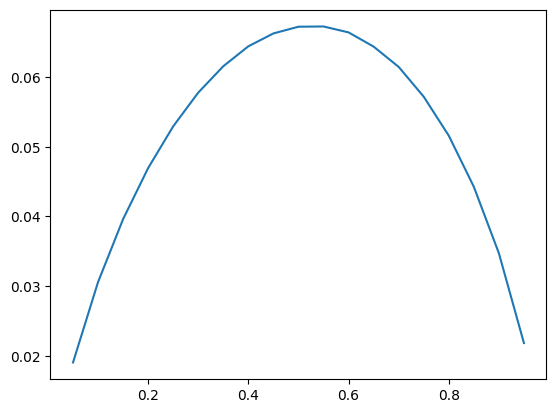

In [ ]:
diff = [Sterns[i]-Paolos[i] for i in range(19)]
plt.plot(ks,diff)
plt.show()

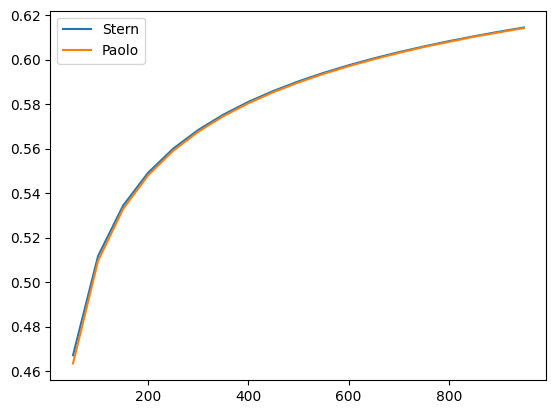

In [ ]:
plt.plot(qs, Sterns_q, label = "Stern")
plt.plot(qs, Paolos_q, label = "Paolo")
plt.legend()
plt.show()

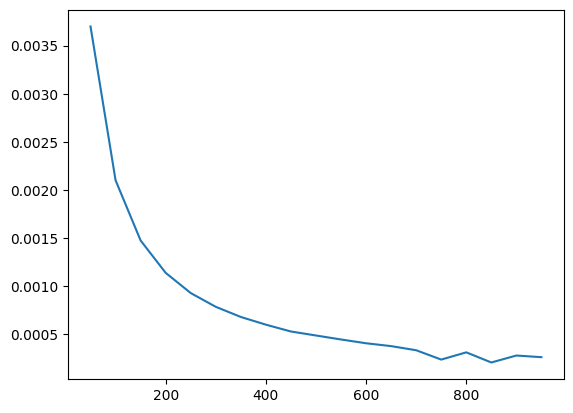

In [ ]:
diff = [Sterns_q[i]-Paolos_q[i] for i in range(19)]
plt.plot(qs,diff)
plt.show()

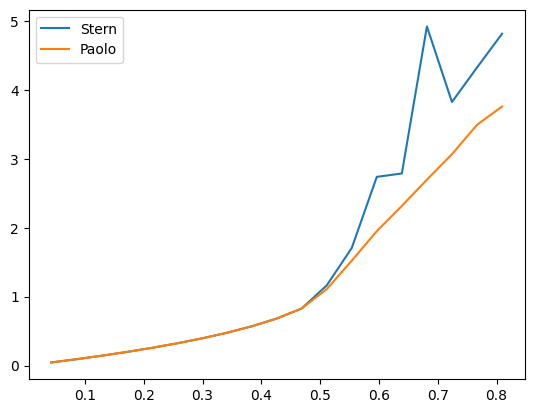

In [ ]:
plt.plot(ws, Sterns_w, label = "Stern")
plt.plot(ws, Paolos_w, label = "Paolo")
plt.legend()
plt.show()

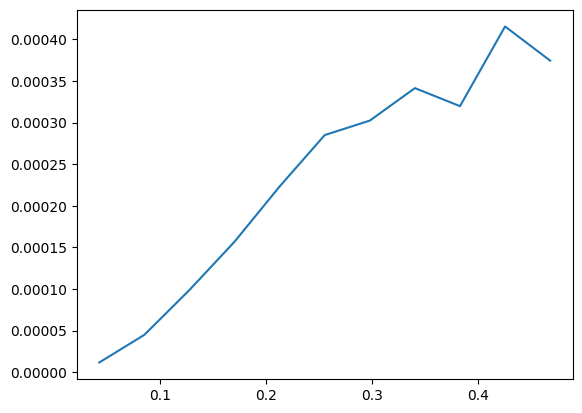

0.42594246710180533


In [ ]:
diff = [Sterns_w[i]-Paolos_w[i] for i in range(11)]
plt.plot(ws[:11],diff)
plt.show()
print(Hqi(0.5,10000))

### Paolos MitM 2 layer - has issues

In [ ]:
set_vars = collections.namedtuple('Our', 'p ell d1 d2 i1 i2 l0 l1')
def our(f) : return wrap(f, set_vars)
k = 0.5
q = 50
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)

p2 = lambda x: x.p/2+x.d2
p1 = lambda x: p2(x)/2+x.d1
r1 = lambda x: binomH(p2(x)-2*x.i1,p2(x)/2 - x.i1) + binomH(p2(x),2*x.i1) + 2*x.i1*log2(q-2) + binomH(k+x.ell-p2(x),x.d1-x.i1) + (x.d1-x.i1)*log2(q-1)
r2 = lambda x: binomH(x.p  -2*x.i2,x.p/2   - x.i2) + binomH(x.p  ,2*x.i2) + 2*x.i2*log2(q-2) + binomH(k+x.ell-x.p  ,x.d2-x.i2) + (x.d2-x.i2)*log2(q-1)
L0 = lambda x: binomH(k+x.ell,p1(x)) - binomH(x.l0,p1(x))
T1 = lambda x: 2*L0(x) - (x.l1-x.l0)*log2(q)
P1 = lambda x: min(0,r1(x)-x.l0*log2(q))
L1 = lambda x: binomH(k+x.ell , p2(x)) + log2(q-1)*p2(x) - x.l1*log2(q)
P2 = lambda x: min(0,r2(x)-x.l1*log2(q))
T2 = lambda x: 2*L1(x) - (x.ell-x.l1)*log2(q)


constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p   - x.d2)},
    #{ 'type' : 'ineq',   'fun' : our(lambda x : 0.01 - memory(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - p2(x) - x.d1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell - (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.ell-x.l1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.l1-x.l0)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2   - x.i2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : p2(x)/2 - x.i1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d2-x.i2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d1-x.i1)},   
    { 'type' : 'ineq',   'fun' : our(lambda x : x.l0-p1(x))},  

]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    return -P2(x) + perms(x) + max(-P1(x) + L0(x),L1(x),-P1(x) + T1(x),T2(x))

def optimize(verb=False, cons=constraints):
    variables = 8
    start = r(0,0.1,variables)
    bounds = [(0, 1)]*2+[(0, 0.1)]*(variables-2)

    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-7, 
            constraints=cons, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations,cons=constraints):
    mini=100
    for i in range(iterations):
        x=optimize(cons=cons)
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

def optimize_mem_constrain(iterations,mem,verb=False):
    constraints_mem = constraints + [{ 'type' : 'ineq',   'fun' : our(lambda x : mem - memory(x))}]
    return iterate_optimizer(iterations,cons=constraints_mem)

def iterate_optimizer_mem(iterations,mem):
    mini=100
    for i in range(iterations):
        x=optimize_mem_constrain(mem)
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_8076\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [ ]:
res=iterate_optimizer(300)
x=set_vars( *res.x)
res.fun

0.46394678933822475

In [ ]:
print("Prange", binomH(1., w) -  binomH(1-k, w))

Prange 0.46894285119697365


In [ ]:
x.p, p2(x),p1(x), x.d1 , x.d2 , x.i1 , x.i2 

(0.01018304573082118,
 0.006075569396911706,
 0.003119684184587356,
 8.189948613150314e-05,
 0.0009840465315011158,
 3.686799097837745e-05,
 0.00047656233818431403)

In [ ]:
x.ell ,  x.l1,  x.l0 

(0.014452047261059848, 0.00797267663707848, 0.0031196841845873564)

In [ ]:
-P1(x) + L0(x),L1(x),-P1(x) + T1(x),T2(x),P2(x)

(0.037159422396931596,
 0.0367363261358567,
 0.03723492108082796,
 0.03690401626971164,
 -0.017243797414163146)

In [ ]:
P1(x),P2(x)

(-0.0026880497453272536, 0)

In [ ]:
r1(x),x.l0*log2(q),r2(x)

(0.00417470627435029, 0.006862756019677544, 0.017797402297904642)

### Meurer BJMM (2 levels)

In [76]:
set_vars = collections.namedtuple('Our', 'p d ell i')
def our(f) : return wrap(f, set_vars)
k = 0.5
q = 2**12
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)

p1 = lambda x: x.p/2+x.d
r1 = lambda x: binomH(x.p-2*x.i,x.p/2 - x.i) + binomH(x.p,2*x.i) + 2*x.i*log2(q-2) + binomH(k+x.ell-x.p,x.d-x.i) + (x.d-x.i)*log2(q-1)
L0 = lambda x: binomH((k+x.ell)/2,p1(x)/2)+ (p1(x)/2)*log2(q-1)
L1 = lambda x: 2*L0(x) - r1(x)
T2 = lambda x: 2*L1(x) - (log2(q)*x.ell-r1(x))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p - x.d)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell- (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-x.i)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d-x.i)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.ell*log2(q)-r1(x))}
]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    return perms(x) + max(L0(x),L1(x),T2(x))

def optimize(verb=False):
    variables=4
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*variables
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_12920\483796357.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [77]:
res=iterate_optimizer(100)
x=set_vars( *res.x)
res.fun

0.659329779618888

In [38]:
L1(x),L0(x),T2(x), r1(x), perms(x)

(0.010354886221944722,
 0.006942739216589911,
 0.010354888360982641,
 0.0035305922112350992,
 0.6065331386314681)

In [39]:
x.p, p1(x),

(0.0011427358035069346, 0.0006609789882704465)

In [40]:
x.ell, x.d, x.i

(0.0013885476294141902, 8.961108651697916e-05, 5.848403865884336e-05)

### Ternary BJMM with variable number of 1's and 2's in base lists

In [ ]:
set_vars = collections.namedtuple('Our', 'p ep0 ep1 ep2 ell')
def our(f) : return wrap(f, set_vars)
k = 0.1
q = 3 ## OBS This algorithm only works for q = 3.
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p) ## Here I don't need extra factor for perfect split between 1's and 2's?

p1 = lambda x: x.ep0 + x.ep1 + x.p/2 - 2*x.ep2
p2 = lambda x: x.ep0 + x.ep2 + x.p/2 - 2*x.ep1
r1 = lambda x: binomH(x.p/2,x.ep1) + binomH(x.p/2-x.ep1,x.ep1) + binomH(x.p/2,x.ep2) + binomH(x.p/2-x.ep2,x.ep2) + binomH(k+x.ell-x.p,x.ep0) + binomH(k+x.ell-x.p-x.ep0,x.ep0)
L0 = lambda x: binomH((k+x.ell)/2,p1(x)/2)+ binomH((k+x.ell-p1(x))/2,p2(x)/2)
L1 = lambda x: 2*L0(x) - r1(x)
T2 = lambda x: 2*L1(x) - (log2(q)*x.ell-r1(x))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell - (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'eq',   'fun' : our(lambda x : p1(x)-p2(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-2*x.ep2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-2*x.ep1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell-x.p-2*x.ep0)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.ell*log2(q)-r1(x))}
]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    return perms(x) + max(L0(x),L1(x),T2(x))

def optimize(verb=False):
    variables=5
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*variables
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_2748\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [ ]:
res=iterate_optimizer(100)

In [ ]:
x=set_vars( *res.x)
res.fun

0.08420885369893122

In [ ]:
time(x)*log(2,q)  #0.05312935773137903

0.053129871312801585

In [ ]:
p1(x),p2(x)

(0.0064266037497253195, 0.0064266037497253195)

### Ternary BJMM with variable number of 1's and 2's in base list with three levels.

In [ ]:
set_vars = collections.namedtuple('Our', 'p ep0 ep1 ep2 de0 de1 de2 ell')
def our(f) : return wrap(f, set_vars)
k = 0.1
q = 3 ## OBS This algorithm only works for q = 3.
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p) ## Here I don't need extra factor for perfect split between 1's and 2's?

q1 = lambda x: x.de0 + x.de1 + x.p/2 - 2*x.de2
q2 = lambda x: x.de0 + x.de2 + x.p/2 - 2*x.de1
p1 = lambda x: x.ep0 + x.ep1 + q1(x) - 2*x.ep2
p2 = lambda x: x.ep0 + x.ep2 + q2(x) - 2*x.ep1
r1 = lambda x: binomH(q1(x),x.ep1) + binomH(q1(x)-x.ep1,x.ep1) + binomH(q2(x),x.ep2) + binomH(q2(x)-x.ep2,x.ep2) + binomH(k+x.ell-q1(x)-q2(x),x.ep0) + binomH(k+x.ell-q1(x)-q2(x)-x.ep0,x.ep0)
r2 = lambda x: binomH(x.p/2,x.de1) + binomH(x.p/2-x.de1,x.de1) + binomH(x.p/2,x.de2) + binomH(x.p/2-x.de2,x.de2) + binomH(k+x.ell-x.p,x.de0) + binomH(k+x.ell-x.p-x.de0,x.de0)
L0 = lambda x: binomH((k+x.ell)/2,p1(x)/2)+ binomH((k+x.ell-p1(x))/2,p2(x)/2)
L1 = lambda x: 2*L0(x) - r1(x)
T2 = lambda x: 2*L1(x) - (r2(x)-r1(x))
L2 = lambda x: binomH(k+x.ell,q1(x)) + binomH(k+x.ell - q1(x),q2(x)) - r2(x)
T3 = lambda x: 2*L2(x) - (log2(q)*x.ell-r2(x))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - q1(x)-q2(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - p1(x)-p2(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell - (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : p1(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : p2(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : q1(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : q2(x))},
    { 'type' : 'eq',   'fun' : our(lambda x : p1(x)-p2(x))},
    { 'type' : 'eq',   'fun' : our(lambda x : q1(x)-q2(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : q2(x)-2*x.ep2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : q1(x)-2*x.ep1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell-q1(x)-q2(x)-2*x.ep0)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-2*x.de1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-2*x.de2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell-x.p-2*x.de0)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.ell*log2(q)-r2(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : r2(x)-r1(x))}
]

def memory(x):
    return max(L0(x),L1(x),L2(x))

def time(x):
    x = set_vars(*x)  
    if  k + x.ell - q1(x)-q2(x) < 0 or k + x.ell - p1(x)-p2(x)<0:
        100
    return perms(x) + max(L0(x),L1(x),T2(x),L2(x),T3(x))

def optimize(verb=False):
    variables=8
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*variables
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_2748\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [ ]:
res=iterate_optimizer(100)

In [ ]:
x=set_vars( *res.x)
res.fun

0.0831012256017449

In [ ]:
time(x)*log(2,q)  
#Meurer:     0.05312937361264773
#Unbalanced: 0.0523705750539989
#Balanced:   0.052375210641126047

0.052431035790395

In [ ]:
L0(x),L1(x),T2(x),T3(x)

(0.03930021228082506,
 0.04595205198853303,
 0.04604830556571901,
 0.0460482738862322)

In [ ]:
p1(x),p2(x)

(0.006330711360164918, 0.006330711360164918)

In [ ]:
q1(x),q2(x)

(0.011842865338062468, 0.011842865338062468)

### Two levels F_5 with variable number of 1,2,3,4's in baselists

In [ ]:
set_vars = collections.namedtuple('Our', 'p ep01 ep02 ep1 ep2 ep3 ep4 ell')
def our(f) : return wrap(f, set_vars)
k = 0.1
q = 5 ## OBS This algorithm only works for q = 5.
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p) 

p1 = lambda x: x.ep01 + x.ep1 + x.ep2 + x.p/4 - 2*x.ep3 - x.ep4
p2 = lambda x: x.ep02 + x.ep4 + x.p/4 - 2*x.ep1 - x.ep2 + x.ep3
p3 = lambda x: p2(x)
p4 = lambda x: p1(x)
r1 = lambda x: 2 * multiH(x.p/4 , [x.ep1,x.ep1,x.ep2,x.ep2]) + 2* multiH(x.p/4,[x.ep3,x.ep3,x.ep4,x.ep4]) + multiH(k+x.ell-x.p,[x.ep01,x.ep01,x.ep02,x.ep02])
L0 = lambda x: multiH((k+x.ell)/2,[p1(x)/2,p2(x)/2,p3(x)/2,p4(x)/2])
L1 = lambda x: 2*L0(x) - r1(x)
T2 = lambda x: 2*L1(x) - (log2(q)*x.ell-r1(x))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell - (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'eq',   'fun' : our(lambda x : p1(x)-p2(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/4-2*x.ep1-2*x.ep2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/4-2*x.ep3-2*x.ep4)},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell-x.p-2*x.ep01-2*x.ep02)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.ell*log2(q)-r1(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : p1(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : p2(x))},
]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    return perms(x) + max(L0(x),L1(x),T2(x))

def optimize(verb=False):
    variables = 8
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*variables
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_2748\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [ ]:
res=iterate_optimizer(100)

In [ ]:
x=set_vars( *res.x)
res.fun

0.1193211078727135

In [ ]:
time(x)*log(2,q)  
#Meurer:     0.05138407659835931
#Unbalanced: 0.05138805873825551
#Balanced:   0.05138880404412429

0.05138880404412429

In [ ]:
L0(x),L1(x),T2(x)

(0.04678771620523717, 0.046817911877485685, 0.04681776356950189)

In [ ]:
p1(x),p2(x)
# Unbalanced: (0.003623650493667255, 0.0036285073657495726)

(0.0034937377831510495, 0.0034937377831510503)

### Meurer BJMM four levels

In [ ]:
set_vars = collections.namedtuple('Our', 'p d1 d2 d3 ell i1 i2 i3')
def our(f) : return wrap(f, set_vars)
k = 0.3
q = 5
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)

p3 = lambda x: x.p/2+x.d3
p2 = lambda x: p3(x)/2+x.d2
p1 = lambda x: p2(x)/2+x.d1
r1 = lambda x: binomH(p2(x)-2*x.i1,p2(x)/2 - x.i1) + binomH(p2(x),2*x.i1) + 2*x.i1*log2(q-2) + binomH(k+x.ell-p2(x),x.d1-x.i1) + (x.d1-x.i1)*log2(q-1)
r2 = lambda x: binomH(p3(x)-2*x.i2,p3(x)/2 - x.i2) + binomH(p3(x),2*x.i2) + 2*x.i2*log2(q-2) + binomH(k+x.ell-p3(x),x.d2-x.i2) + (x.d2-x.i2)*log2(q-1)
r3 = lambda x: binomH(x.p  -2*x.i3,x.p  /2 - x.i3) + binomH(x.p  ,2*x.i3) + 2*x.i3*log2(q-2) + binomH(k+x.ell-x.p  ,x.d3-x.i3) + (x.d3-x.i3)*log2(q-1)
L0 = lambda x: binomH((k+x.ell)/2,p1(x)/2)+ (p1(x)/2)*log2(q-1)
L1 = lambda x: 2*L0(x) - r1(x)
L2 = lambda x: binomH(k+x.ell , p2(x))+log2(q-1)*p2(x) - r2(x)
L3 = lambda x: binomH(k+x.ell , p3(x))+log2(q-1)*p3(x) - r3(x)
T2 = lambda x: 2*L1(x) - (r2(x)-r1(x))
T3 = lambda x: 2*L2(x) - (r3(x)-r2(x))
T4 = lambda x: 2*L3(x) - (log2(q)*x.ell-r3(x))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p - x.d3)},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - p3(x) - x.d2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - p2(x) - x.d1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell - (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2   - x.i3)},
    { 'type' : 'ineq',   'fun' : our(lambda x : p3(x)/2 - x.i2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : p2(x)/2 - x.i1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d3-x.i3)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d2-x.i2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d1-x.i1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : r2(x)-r1(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : r3(x)-r2(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : log2(q)*x.ell-r3(x))}
]

def memory(x):
    return max(L0(x),L1(x),L2(x),L3(x))

def time(x):
    x = set_vars(*x)  
    return perms(x) + max(L0(x),L1(x),L2(x),L3(x),T2(x),T3(x),T4(x))

def optimize(verb=False):
    variables = 8
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*variables
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_12168\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [ ]:
res=iterate_optimizer(200)

In [ ]:
x=set_vars( *res.x)
res.fun

0.21431746222777395

In [ ]:
x.p

0.06896712450853508

In [ ]:
time(x)*log(2,q),memory(x)

(0.09230150696728211, 0.12321638272636745)

In [ ]:
L0(x),L1(x),L2(x),L3(x),T2(x),T3(x),T4(x)

(0.054757159132078174,
 0.07778249515904723,
 0.12315440226379232,
 0.12321638272636745,
 0.12333788397258083,
 0.12333909688324143,
 0.12333905826670435)

In [ ]:
p1(x),p2(x),p3(x),x.p

(0.012895987960935898,
 0.024868105928600878,
 0.04729841480830065,
 0.06896712450853508)

In [ ]:
x.d1,x.d2,x.d3

(0.0004619349966354591, 0.0012188985244505528, 0.012814852554033113)

In [ ]:
x.ell

0.13351935616078406

In [ ]:
x.i1,x.i2,x.i3

(0.0003991184486481427, 0.0010644419071350005, 0.0018263770622165517)

### Meurer BJMM 3 levels

In [ ]:
set_vars = collections.namedtuple('Our', 'p ell d1 d2 i1 i2')
def our(f) : return wrap(f, set_vars)
k = 0.5
q = 50
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)

p2 = lambda x: x.p/2+x.d2
p1 = lambda x: p2(x)/2+x.d1
r1 = lambda x: binomH(p2(x)-2*x.i1,p2(x)/2 - x.i1) + binomH(p2(x),2*x.i1) + 2*x.i1*log2(q-2) + binomH(k+x.ell-p2(x),x.d1-x.i1) + (x.d1-x.i1)*log2(q-1)
r2 = lambda x: binomH(x.p  -2*x.i2,x.p/2   - x.i2) + binomH(x.p  ,2*x.i2) + 2*x.i2*log2(q-2) + binomH(k+x.ell-x.p  ,x.d2-x.i2) + (x.d2-x.i2)*log2(q-1)
L0 = lambda x: binomH((k+x.ell)/2,p1(x)/2)+ (p1(x)/2)*log2(q-1)
L1 = lambda x: 2*L0(x) - r1(x)
L2 = lambda x: binomH(k+x.ell , p2(x)) + log2(q-1)*p2(x) - r2(x)
T2 = lambda x: 2*L1(x) - (r2(x)-r1(x))
T3 = lambda x: 2*L2(x) - (log2(q)*x.ell-r2(x))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p   - x.d2)},
    #{ 'type' : 'ineq',   'fun' : our(lambda x : 0.01 - memory(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - p2(x) - x.d1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell - (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2   - x.i2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : p2(x)/2 - x.i1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d2-x.i2)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d1-x.i1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : r2(x)-r1(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : log2(q)*x.ell-r2(x))}    
]

def memory(x):
    return max(L0(x),L1(x),L2(x))

def time(x):
    x = set_vars(*x)  
    return perms(x) + max(L0(x),L1(x),L2(x),T2(x),T3(x))

def optimize(verb=False, cons=constraints):
    variables = 6
    start = r(0,0.1,variables)
    bounds = [(0, 1)]*2+[(0, 0.1)]*(variables-2)

    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-7, 
            constraints=cons, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations,cons=constraints):
    mini=10000
    for i in range(iterations):
        x=optimize(cons=cons)
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

def optimize_mem_constrain(iterations,mem,verb=False):
    constraints_mem = constraints + [{ 'type' : 'ineq',   'fun' : our(lambda x : mem - memory(x))}]
    return iterate_optimizer(iterations,cons=constraints_mem)

def iterate_optimizer_mem(iterations,mem):
    mini=10000
    for i in range(iterations):
        x=optimize_mem_constrain(mem)
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

C:\Users\freja\AppData\Local\Temp\ipykernel_8076\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [ ]:
res=iterate_optimizer(300)
x=set_vars( *res.x)
res.fun

0.46384578657296993

In [ ]:
print("Prange", binomH(1., w) -  binomH(1-k, w))

Prange 0.46894285119697365


In [ ]:
time(x)*log(2,q),memory(x)

(0.0821859684187815, 0.10904215715751042)

In [ ]:
L0(x),L1(x),L2(x),T2(x),T3(x)

(0.05728717973130746,
 0.0969090362020123,
 0.10904215715751042,
 0.10925436648988447,
 0.10919418813955586)

In [ ]:
l0 = r1(x)/log2(q)
l1 = r2(x)/log2(q)

In [ ]:
print("alternative level 1", binomH(k+x.ell, p1(x))-binomH(l0,p1(x)))
print(l0,p1(x))
print("alternative level 2", binomH(k+x.ell, p2(x))-binomH(l1,p2(x)))
print(l1,p2(x))


alternative level 1 3.1949945935376625
0.003130009459243102 0.008832019203989518
alternative level 2 0.10905648246637106
0.018113329917930323 0.017663983306525285


In [ ]:
x.ell,x.p

(0.037406898448742114, 0.025514750225075176)

In [ ]:
r1(x),r2(x), r1(x)/log2(q),r2(x)/log2(q)

(0.0023911621462081056,
 0.012373767001850985,
 0.0005532628247648863,
 0.0028630200989434714)

In [ ]:
p1(x),p2(x), x.p

(0.0009974638142605165, 0.0019527700486648674, 0.002437193851785201)

In [ ]:
x.d1,x.d2

(2.107878992808274e-05, 0.000734173122772267)

In [ ]:
q = 50
ks = np.arange(0.05,1,0.05)
p1s = []
p2s = []
l1s = []
l2s = []
for k in ks:
    w = Hqi(1-k,q)
    res=iterate_optimizer(300)
    x=set_vars( *res.x)
    p1s.append(p1(x))
    p2s.append(p2(x))
    l1s.append(r1(x)/log2(q))
    l2s.append(r2(x)/log2(q))
    print(k)

C:\Users\freja\AppData\Local\Temp\ipykernel_8076\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
0.8
0.8500000000000001
0.9000000000000001
0.9500000000000001


In [ ]:
qs = [3,5,10,30,50,100,200,500,1000]
k = 0.5
p1qs = []
p2qs = []
l1qs = []
l2qs = []
for q in qs:
    w = Hqi(1-k,q)
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    p1qs.append(p1(x))
    p2qs.append(p2(x))
    l1qs.append(r1(x)/log2(q))
    l2qs.append(r2(x)/log2(q))
    print(q)

C:\Users\freja\AppData\Local\Temp\ipykernel_8076\1409435978.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


3
5
10
30
50
100
200
500
1000


In [ ]:
for i in range(1,10):
    mem=i*0.005
    res=optimize_mem_constrain(300,mem)
    x=set_vars( *res.x)
    print(res.fun)

0.08819438666125733
0.0884229431219137
0.08633968237851579
0.08562776975832147
0.08500070564037576
0.08438257206263591
0.08385990406494173
0.0834100108465318
0.08311757252500691


### Basefield BJMM 2 levels

In [78]:
set_vars = collections.namedtuple('Our', 'p ell e1 a1 g1 d1')
def our(f) : return wrap(f, set_vars)
k = 0.5
m = 12
q = 2**m
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)
prob = lambda x: x.p*(log2(binom(m,m/2))-log2(q-1))

p1 = lambda x: x.p/2 + x.e1
r1 = lambda x: binomH(k-x.ell-x.p,x.g1) + x.g1*log2(binom(m,m*x.a1)) + multiH(x.p,[x.p/2 - x.e1, 2*x.e1]) + 2*x.e1*log2(binom(m/2,m*x.d1-m/4)) + 2*x.e1*log2(binom(m/2,m/4))
L0 = lambda x: multiH((k+x.ell)/2,[p1(x)/2,x.g1/2]) + p1(x)/2*log2(binom(m,m*x.d1)) + x.g1/2*log2(binom(m,m*x.a1))
L1 = lambda x: 2*L0(x) - r1(x)
T2 = lambda x: 2*L1(x) - (m*x.ell-r1(x))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p - x.g1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell- (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-x.e1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.ell*m-r1(x))}
]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    return perms(x) - prob(x) + max(L0(x),L1(x),T2(x))

def optimize(verb=False):
    variables=6
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*5 + [(1/4,3/4)]
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result


C:\Users\freja\AppData\Local\Temp\ipykernel_12920\483796357.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [79]:
res=iterate_optimizer(100)
x=set_vars( *res.x)
res.fun

0.6592534293502259

In [64]:
L1(x),L0(x),T2(x),perms(x), prob(x), r1(x)

(0.00734529395853859,
 0.004165177622354525,
 0.0073452937791968955,
 0.6075323524404707,
 -0.0018841346418690364,
 0.000985061286170459)

In [65]:
x.p, p1(x),

(0.0009321351845980456, 0.0004683589772559862)

In [66]:
x.ell, x.e1, x.a1, x.g1, x.d1

(0.0008330355424050743,
 2.291384956963429e-06,
 0.021648319400936276,
 1.2242083391055924e-13,
 0.25000000000000044)

In [67]:
i = x.e1
d = x.e1+x.g1
mr1 = lambda x: binomH(x.p-2*i,x.p/2 - i) + binomH(x.p,2*i) + 2*i*log2(q-2) + binomH(k+x.ell-x.p,d-i) + (d-i)*log2(q-1)
mr1(x)

0.0010151039388674005

### Basefield BJMM integer

In [86]:
set_vars = collections.namedtuple('Our', 'p ell e1')
def our(f) : return wrap(f, set_vars)
k = 0.5
m = 12
q = 2**m
w = Hqi(1-k,q)

perms = lambda x: binomH(1., w) - binomH(k+x.ell, x.p) - binomH(1-k-x.ell, w-x.p)
prob = lambda x: x.p*(log2(sum([binom(m,i) for i in range(m//2-s , m//2+s+1,2)]))-log2(q-1))

p1 = lambda x: x.p/2 + x.e1
r1 = lambda x: multiH(x.p,[x.p/2 - x.e1, 2*x.e1]) + 2*x.e1*min([log2(binom(m-j,d1-j/2)) + log2(binom(j,j/2)) for j in range(m//2-s , m//2+s+1,2)])
L0 = lambda x: binomH((k+x.ell)/2,p1(x)/2) + p1(x)/2*log2(binom(m,d1))
L1 = lambda x: 2*L0(x) - r1(x)
T2 = lambda x: 2*L1(x) - (m*x.ell-r1(x))

constraints = [
    { 'type' : 'ineq',   'fun' : our(lambda x : k + x.ell - x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell- (w-x.p))},
    { 'type' : 'ineq',   'fun' : our(lambda x : 1-k-x.ell)},
    { 'type' : 'ineq',   'fun' : our(lambda x : w-x.p)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.p/2-x.e1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.ell*m-r1(x))}
]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    return perms(x) - prob(x) + max(L0(x),L1(x),T2(x))

def optimize(verb=False):
    variables=3
    start = r(0,0.008,variables)
    bounds = [(0, 1)]*variables
    
    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-10, 
            constraints=constraints, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations):
    mini=100
    for i in range(iterations):
        x=optimize()
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result


C:\Users\freja\AppData\Local\Temp\ipykernel_12920\483796357.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return fsolve(lambda x:v -(x*log(q-1,q)-x*log(x,q)-(1-x)*log(1-x,q)),0.0000001)[0]


In [87]:
6592534293502259

for s in range(0,math.floor(m/2),2):
    for d1 in range(math.ceil(m/4+s/2),1+math.floor(3*m/4-s/2)):
        res=iterate_optimizer(100)
        x=set_vars( *res.x)
        print(s,d1,res.fun)

0 3 0.6592534540437341
0 4 0.6593859809615626
0 5 0.6594132694835149
0 6 0.6594186864649992
0 7 0.6594132716629102
0 8 0.6593859828720547
0 9 0.6592534301780778
2 4 0.6590961900978731
2 5 0.6592702280508627
2 6 0.6593054066552239
2 7 0.6592702355378691
2 8 0.6590961958532316
4 5 0.6592389371490139
4 6 0.6592797327270722
4 7 0.6592389426459959


In [ ]:
L1(x),L0(x),T2(x),perms(x), prob(x), r1(x)

(0.007412697270078684,
 0.0042065901459030055,
 0.007412500400272402,
 0.6074457237623736,
 -0.0019034621060460698,
 0.0010004830217273275)

In [ ]:
x.p, p1(x),

(0.0009416970327739274, 0.00047342865559751765)

In [ ]:
x.ell, x.e1, x.a1, x.g1, x.d1

(0.0008413377161612292,
 2.5801392105539526e-06,
 0.2220565068105126,
 3.064541750765914e-14,
 0.7499999999478197)

In [ ]:
i = x.e1
d = x.e1+x.g1
mr1 = lambda x: binomH(x.p-2*i,x.p/2 - i) + binomH(x.p,2*i) + 2*i*log2(q-2) + binomH(k+x.ell-x.p,d-i) + (d-i)*log2(q-1)
mr1(x)

0.0010343115686764321

### Comparing different ways to construct sublists - linalg or BJMM 2 level

In [ ]:
set_vars = collections.namedtuple('Our', 'd1 i1')
def our(f) : return wrap(f, set_vars)



p1 = lambda x: p/2+x.d1
r1 = lambda x: binomH(p-2*x.i1,p/2 - x.i1) + binomH(p,2*x.i1) + 2*x.i1*log2(q-2) + binomH(k+ell-p,x.d1-x.i1) + (x.d1-x.i1)*log2(q-1)
L0 = lambda x: binomH((k+ell)/2,p1(x)/2)+ (p1(x)/2)*log2(q-1)
L1 = lambda x: 2*L0(x) - r1(x)
T2 = lambda x: 2*L1(x) - (log2(q)*ell-r1(x))


constraints = [

    #{ 'type' : 'ineq',   'fun' : our(lambda x : 0.01 - memory(x))},
    { 'type' : 'ineq',   'fun' : our(lambda x : k + ell - p - x.d1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : p/2 - x.i1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : x.d1-x.i1)},
    { 'type' : 'ineq',   'fun' : our(lambda x : log2(q)*ell-r1(x))}    
]

def memory(x):
    return max(L0(x),L1(x))

def time(x):
    x = set_vars(*x)  
    return max(L0(x),L1(x),T2(x))

def optimize(verb=False, cons=constraints):
    variables = 2
    start = r(0,0.1,variables)
    bounds = [(0, 1)]*2+[(0, 0.1)]*(variables-2)

    result = opt.minimize(time, start, 
            bounds= bounds, tol=1e-7, 
            constraints=cons, options={'maxiter':1000})
    astuple = set_vars(*result.x) 
    x = set_vars(*result.x)    
    return result

def iterate_optimizer(iterations,cons=constraints):
    mini=10000
    for i in range(iterations):
        x=optimize(cons=cons)
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

def optimize_mem_constrain(iterations,mem,verb=False):
    constraints_mem = constraints + [{ 'type' : 'ineq',   'fun' : our(lambda x : mem - memory(x))}]
    return iterate_optimizer(iterations,cons=constraints_mem)

def iterate_optimizer_mem(iterations,mem):
    mini=10000
    for i in range(iterations):
        x=optimize_mem_constrain(mem)
        if x.success and x.fun<mini:
            mini=x.fun
            result = x
    return result

In [ ]:
res=iterate_optimizer(100)
x=set_vars( *res.x)
res.fun

0.0424998939126803

In [ ]:
L0(x),L1(x),L2(x),T2(x),T3(x)

(0.011935570308238365,
 0.01872063883598255,
 0.0316238764327144,
 0.031640388390784646,
 0.0424998939126803)

In [ ]:
binomH(k+ell,p)-binomH(ell,p)

0.044199143780068686

In [ ]:
binomH(k+ell,p) + p*log2(q-1) - ell*log2(q)

0.04249989376564556

In [ ]:
q = 50
BJMMs = []
opts = []
linalgs = []
for i in range(19):
    k = ks[i]
    p = p2s[i]
    ell = l2s[i]
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    BJMMs.append(res.fun)
    opts.append(binomH(k+ell,p) + p*log2(q-1) - ell*log2(q))
    linalgs.append(binomH(k+ell,p)-binomH(ell,p))

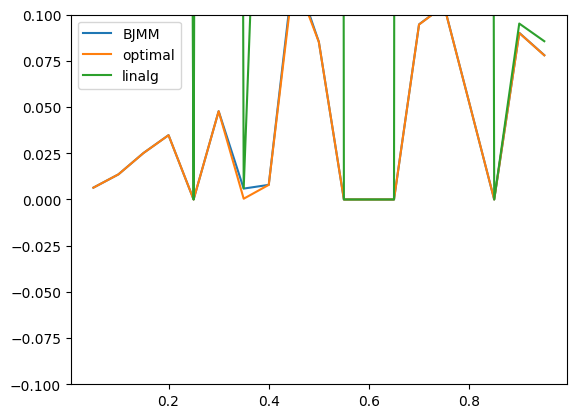

In [ ]:
plt.plot(ks,BJMMs, label = "BJMM")
plt.plot(ks,opts, label = "optimal")
plt.plot(ks,linalgs,label = "linalg")
plt.legend()
ax = plt.gca()
#ax.set_xlim([xmin, xmax])
ax.set_ylim([-0.1, 0.1])
plt.show()

In [ ]:
k = 0.5
BJMMqs = []
optqs = []
linalgqs = []
for i in range(len(qs)):
    q = qs[i]
    p = p2s[i]
    ell = l2s[i]
    res=iterate_optimizer(100)
    x=set_vars( *res.x)
    BJMMqs.append(res.fun)
    optqs.append(binomH(k+ell,p) + p*log2(q-1) - ell*log2(q))
    linalgqs.append(binomH(k+ell,p)-binomH(ell,p))

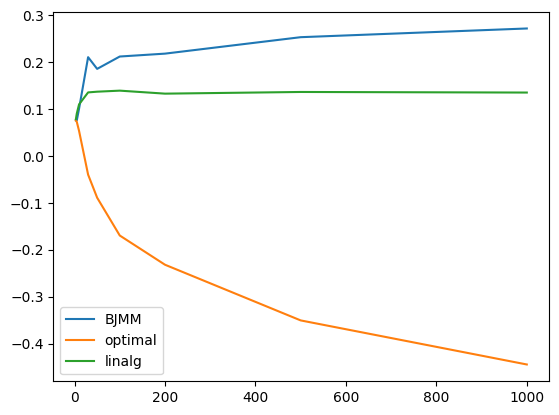

In [ ]:
plt.plot(qs[0:],BJMMqs[0:], label = "BJMM")
plt.plot(qs[0:],optqs[0:], label = "optimal")
plt.plot(qs[0:],linalgqs[0:],label = "linalg")
plt.legend()
plt.show()